# Tarefa Final

Nessa tarefa nós vamos usar o seguinte dataset do Kaggle sobre [fake news](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).
Onde nós vamos tentar classificar o que é fake news e o que é "Real News". Usaremos também o seguinte [dataset](https://www.kaggle.com/icw123/glove-twitter) para utilizar o metodo que foi descrito nesse notebook.



## Porque Fake News são um problema

As notícias falsas referem-se a desinformação, desinformação ou má informação, que são disseminadas pelo boca a boca e pela mídia tradicional e, mais recentemente, por formas digitais de comunicação, como vídeos editados, memes, anúncios não verificados e rumores propagados pelas mídias sociais. tornou-se um problema sério, com o potencial de resultar em violência da multidão, suicídios etc. como resultado de informações erradas circuladas nas mídias sociais.


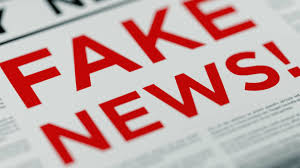




##Breve descrição do dataset
Esse conjunto de dados consiste em cerca de 40000 artigos, consistindo em notícias falsas e reais. Nosso objetivo é treinar nosso modelo para que ele possa prever corretamente se uma notícia é real ou falsa. Os dados de notícias falsas e reais são dados em dois conjuntos de dados separados, com cada conjunto de dados em torno de 20000 artigos cada.

## Carregando as Bibliotecas Necessárias

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

%matplotlib inline
! pip install nltk

path_1 = '/content/drive/My Drive/Visualização de Dados/Tarefa Final/data/Fake.csv'

path_2 = "/content/drive/My Drive/Visualização de Dados/Tarefa Final/data/True.csv"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Carregando a data

true = pd.read_csv(path_2)
false = pd.read_csv(path_1)

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true['category'] = 1
false['category'] = 0
data = pd.concat([true,false]) #Juntando os 2 datasets

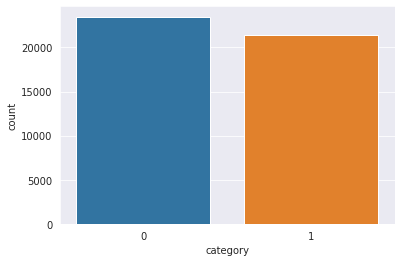

In [ ]:
sns.set_style("darkgrid")
sns.countplot(data.category)

Os dados estão bem balanceado

In [ ]:
data.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
# Checando valores null
data.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [ ]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

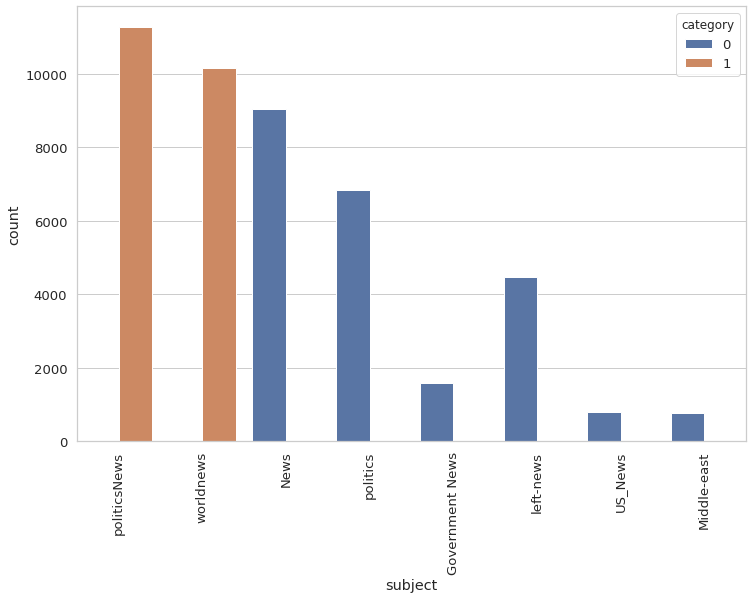

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**DESDE QUE OS TÓPICOS DA COLUNA SUBJECTS SÃO DIFERENTES PARA AS DUAS CATEGORIAS, POR ISSO TEMOS QUE EXCLUÍ-LO DA COLUNA FINAL DE TEXTO**


In [ ]:
data['text'] = data['text'] + " " + data['title']
del data['title']
del data['subject']
del data['date']

## Vamos Introduzir agora os Stopword

Stopwords são as palavras em inglês que não agregam muito significado a uma frase. Eles podem ser ignorados com segurança sem sacrificar o significado da frase. Por exemplo, palavras como o, ele, tem etc. Essas palavras já são capturadas no corpus denominado corpus. Primeiro, fazemos o download para o nosso ambiente python.


In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Limpeza de dados

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
data['text']=data['text'].apply(denoise_text)


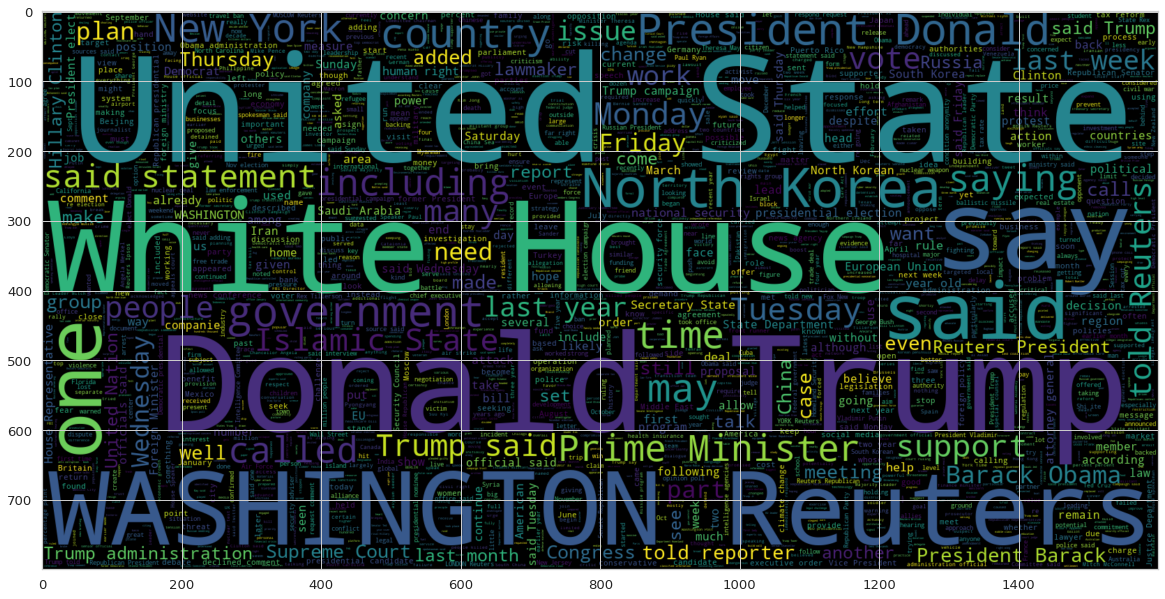

In [ ]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

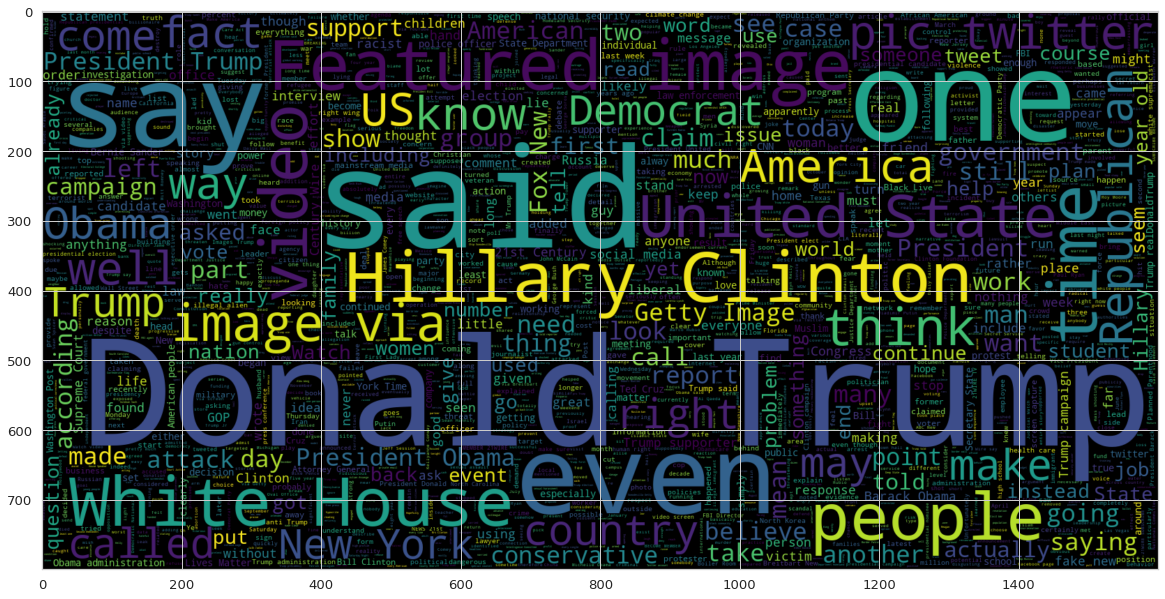

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')


**Número de caracteresc em texto**

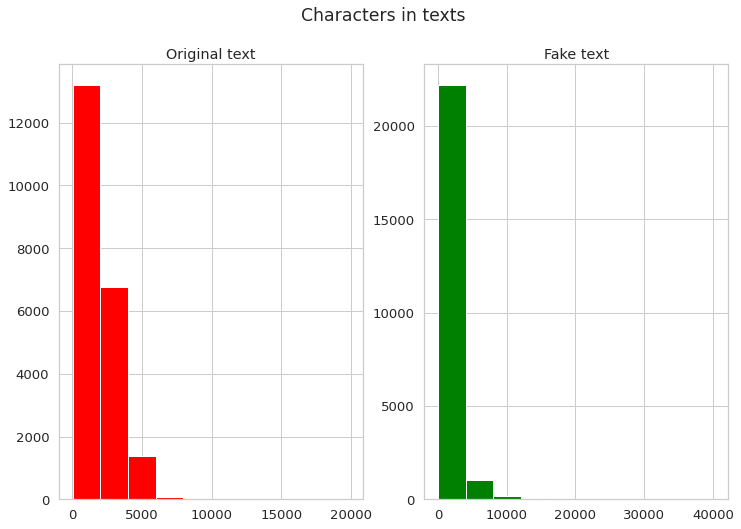

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=data[data['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

**A distribuição de ambos parece ser um pouco diferente. 2500 caracteres no texto são os mais comuns na categoria de texto original, enquanto cerca de 5000 caracteres no texto são mais comuns na categoria de texto falso.**

**Número de palavras em cada texto**


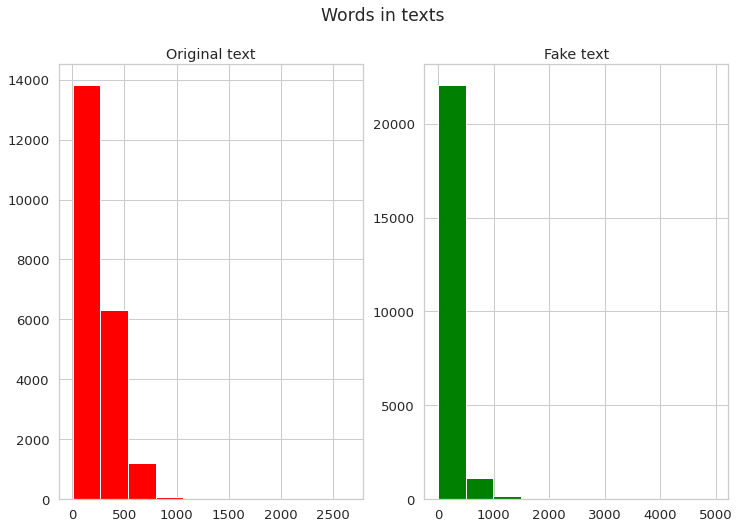

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=data[data['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**Comprimento médio da palavra em um texto**

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

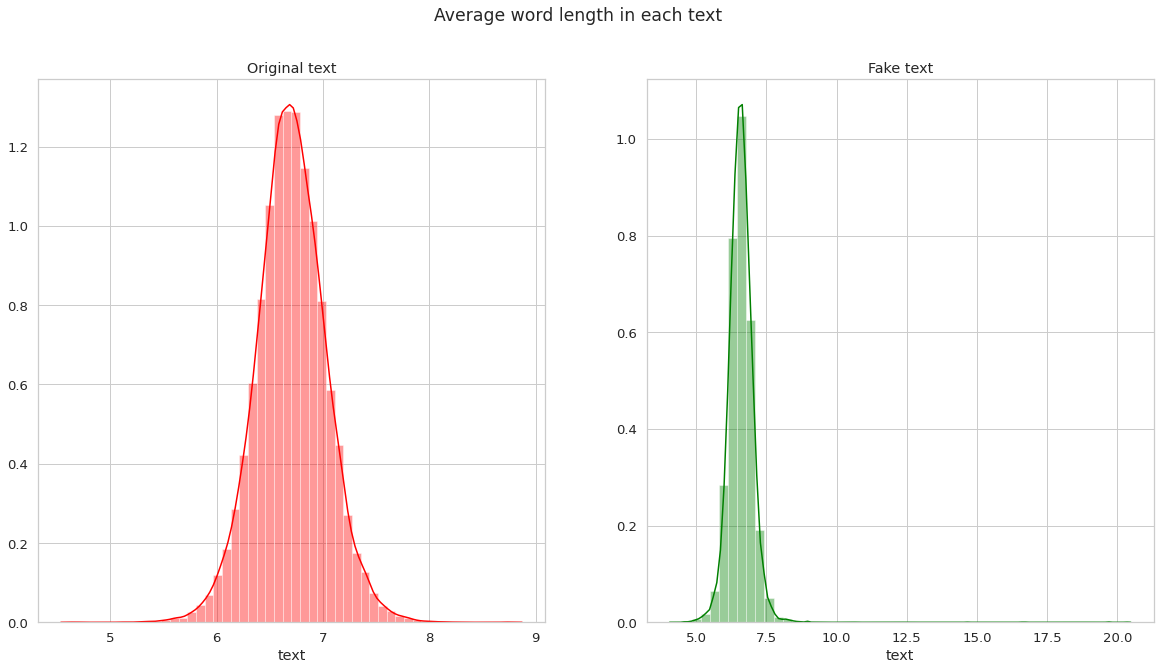

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=data[data['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27795,
 'President': 33180,
 'Trump': 111503,
 'U.S.': 50441,
 'also': 30325,
 'one': 29370,
 'people': 33115,
 'said': 93162,
 'said.': 26194,
 'would': 54613}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Unigram analyze

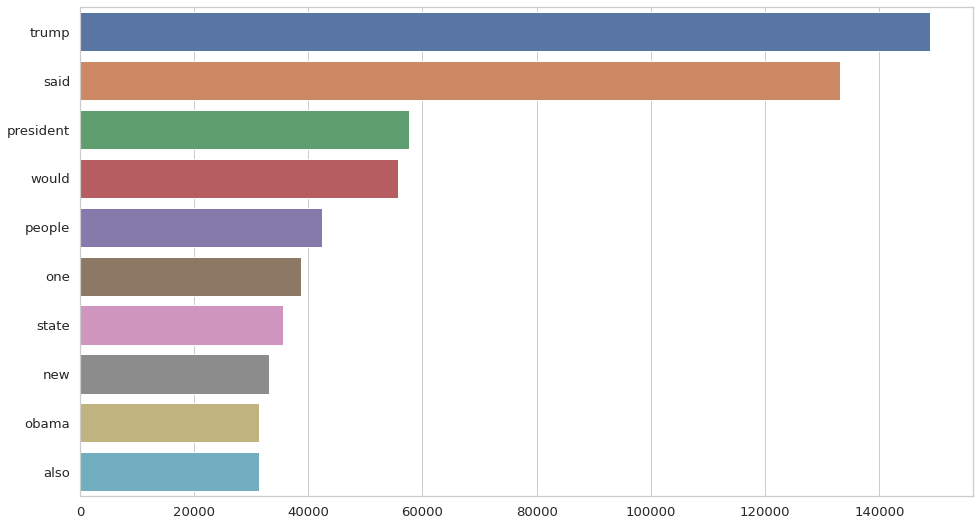

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(data.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

## Bigram Analysis



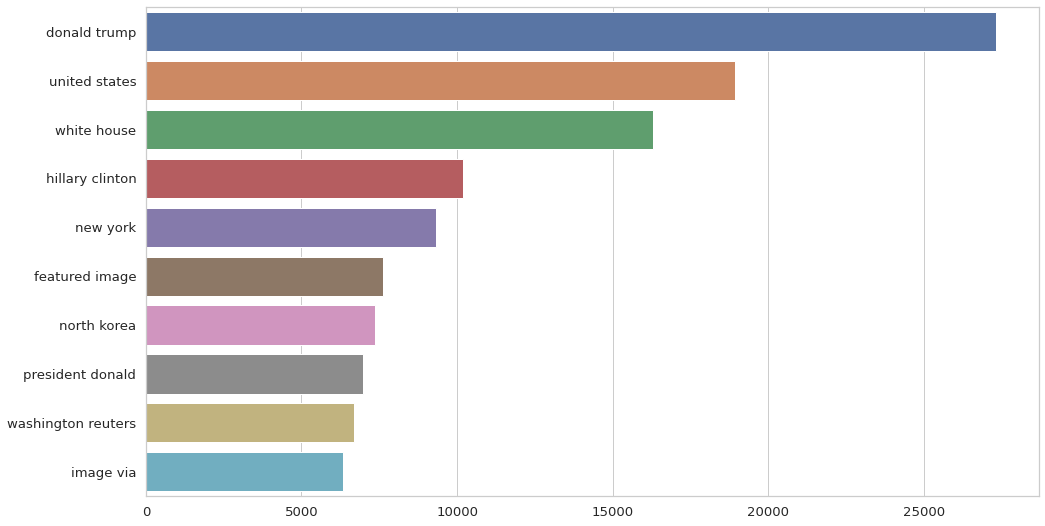

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

## Trigram Analysis

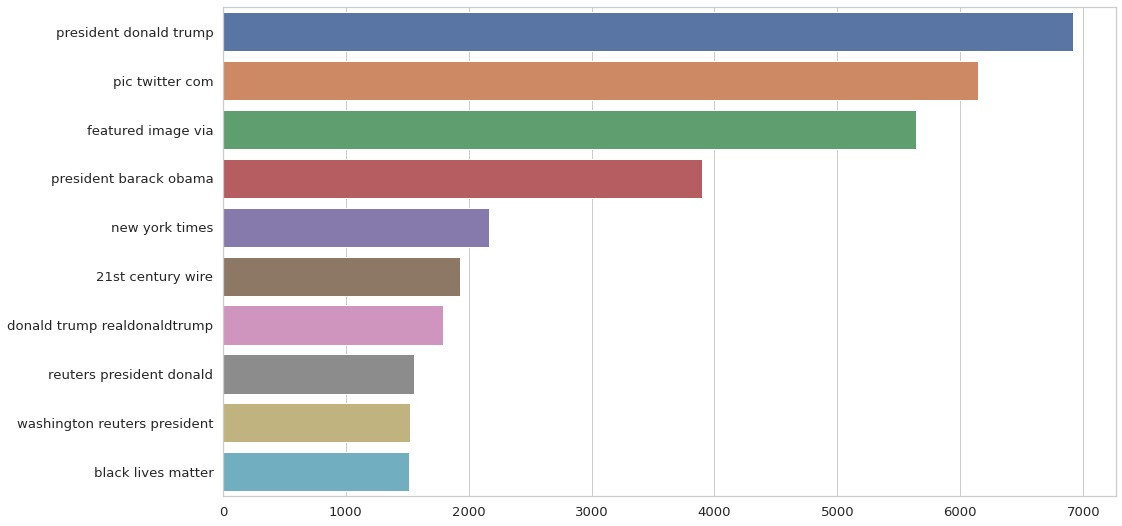

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(data.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

## Separando a data em 2 partes - training e testing data

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data.text,data.category,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

**Tokenizando Texto -> Representando cada palavra por um número**

**O mapeamento da palavra original para o número é preservado na propriedade word_index do tokenizer**

**Tokenizado aplica processamento básico, como alterá-lo para minúsculas, definindo explicitamente que como False**

**Permite manter todas as notícias em 300, adicionar preenchimento a notícias com menos de 300 palavras e truncar palavras longas**

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Introdução ao GLoVe

O método GloVe baseia-se em uma ideia importante: você pode derivar relações semânticas entre palavras da matriz de coocorrência. Dado um corpus com palavras em V, a matriz de co-ocorrência X será uma matriz em V x V, onde a iª linha e a j-ésima coluna de X, X_ij indica quantas vezes a palavra eu co-ocorreu com a palavra j. Um exemplo de matriz de co-ocorrência pode ter a seguinte aparência.

Esse metodo foi tirado do seguinte [site](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010://)

In [ ]:
EMBEDDING_FILE = '/content/drive/My Drive/Visualização de Dados/Tarefa Final/glover_twitter/glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


Parametros do modelo

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)


**Treinando o modelo**

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])


Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 147s 4ms/step - loss: 0.1557 - accuracy: 0.9372 - val_loss: 0.0456 - val_accuracy: 0.9846
Epoch 2/10
33673/33673 [==============================] - 144s 4ms/step - loss: 0.0437 - accuracy: 0.9855 - val_loss: 0.0127 - val_accuracy: 0.9965
Epoch 3/10
33673/33673 [==============================] - 143s 4ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0076 - val_accuracy: 0.9972
Epoch 4/10
33673/33673 [==============================] - 142s 4ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0068 - val_accuracy: 0.9975
Epoch 5/10
33673/33673 [==============================] - 143s 4ms/step - loss: 0.0131 - accuracy: 0.9958 - val_loss: 0.0067 - val_accuracy: 0.9980
Epoch 6/10
33673/33673 [==============================] - 144s 4ms/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0061 - val_accuracy: 0.9982
Epoch 7/10
33673/33673 [==============================] - 142s

# Analise após o treinamento do modelo

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

33673/33673 [==============================] - 95s 3ms/step
Accuracy of the model on Training Data is -  99.9703049659729 %
11225/11225 [==============================] - 32s 3ms/step
Accuracy of the model on Testing Data is -  99.82182383537292 %


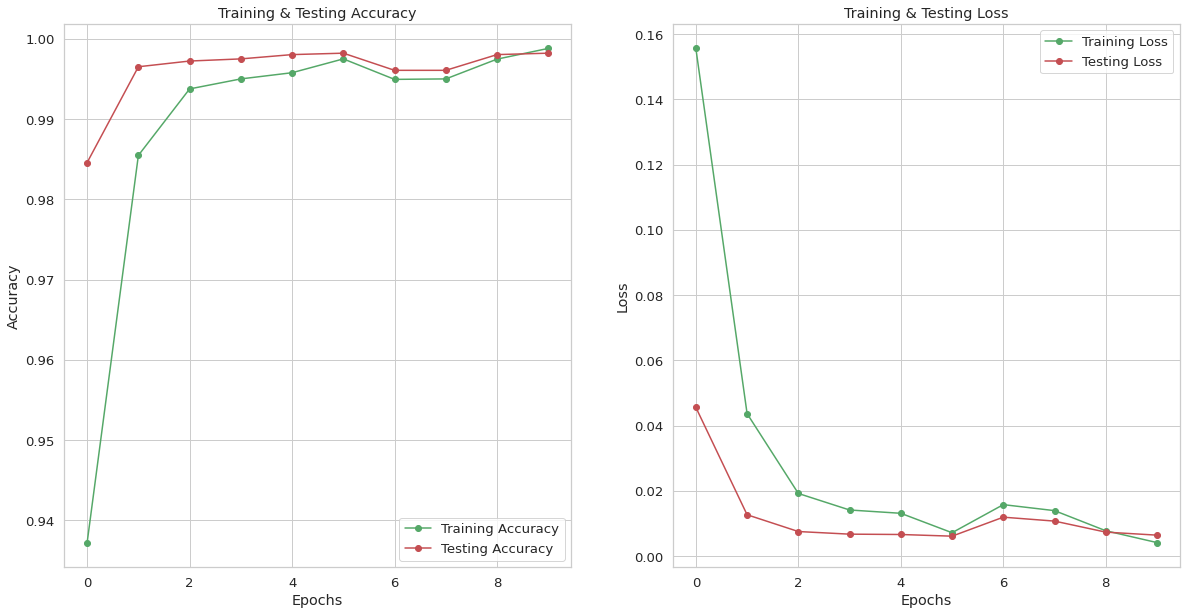

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))


              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
cm = confusion_matrix(y_test,pred)
cm


array([[5851,    7],
       [  13, 5354]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])


Text(63.5, 0.5, 'Actual')

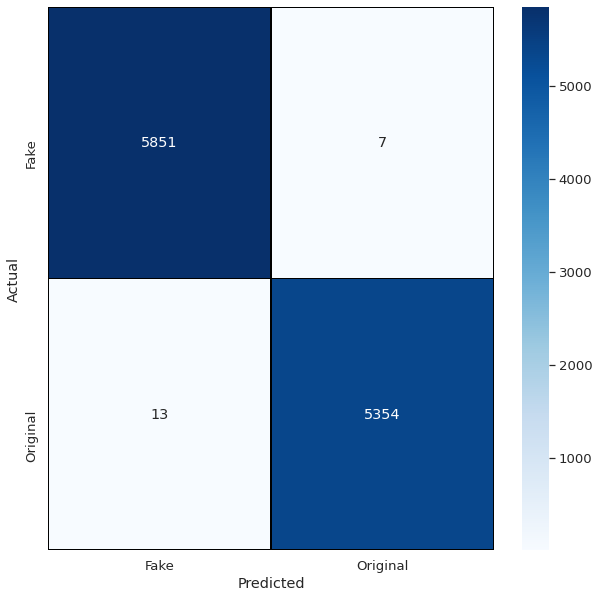

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
